# EDA ranks lasts cups

## Importing libraries

In [588]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

### Reading the database

using database "international_matches.csv" from:  https://www.kaggle.com/datasets/brenda89/fifa-world-cup-2022/code That has the fifa rank scores 

In [589]:
df = pd.read_csv('data/international_matches.csv', parse_dates=['date'])
df['date'] = pd.to_datetime(df['date'])
df.tail()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


### Data analysis 

auxiliar function to get last registers by team in FiFA rank

In [590]:
def get_last_register_in_FIFA(df):
    index_list=[]
    for team in df['team'].unique():
        index_list.append(df['date'][df['team']==team].idxmax())
    return df[df.index.isin(index_list)]

#### Filter the teams participating in QATAR - World cup 2022


In [591]:
list_2022 = ['Qatar', 'Germany', 'Denmark', 'Brazil', 'France', 'Belgium', 'Croatia', 'Spain', 'Serbia', 'England', 'Switzerland', 'Netherlands', 'Argentina', 'IR Iran', 'Korea Republic', 'Japan', 'Saudi Arabia', 'Ecuador', 'Uruguay', 'Canada', 'Ghana', 'Senegal', 'Portugal', 'Poland', 'Tunisia', 'Morocco', 'Cameroon', 'USA', 'Mexico', 'Wales', 'Australia', 'Costa Rica']
master_df = df[(df["home_team"].apply(lambda x: x in list_2022)) | (df["away_team"].apply(lambda x: x in list_2022))]

##### separating  values from home_team and away_team 

drop non used values 

In [592]:
master_df=master_df.drop(columns=['tournament', 'city', 'country', 'neutral_location', 'shoot_out'])

inser the away_team_result in dataset

In [593]:
away_team_result=[]
for value in master_df['home_team_result']:
    if value =='Win':
        away_team_result.append('Lose')
    elif value =='Lose':
        away_team_result.append('Win')
    else:
        away_team_result.append(value)

master_df.insert(12, "away_team_result", away_team_result)

In [594]:
home= master_df[['date']].copy()
away= master_df[['date']].copy()

for column in master_df.iloc[:,1:].columns:
    if 'home' in column:
        home[column] = master_df[column]
    elif 'away' in column:
        away[column] = master_df[column]

#### Fifa features in last FIFA date

In [595]:
home = home.rename(columns={"home_team":"team"})
away = away.rename(columns={"away_team":"team"})

home=get_last_register_in_FIFA(home)
away=get_last_register_in_FIFA(away)
fifa_features=pd.merge(home.drop(columns=['date']), away.drop(columns=['date']))
fifa_features

,team,home_team_continent,home_team_fifa_rank,home_team_total_fifa_points,home_team_score,home_team_result,home_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_continent,away_team_fifa_rank,away_team_total_fifa_points,away_team_score,away_team_result,away_team_goalkeeper_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,Tahiti,Oceania,154,0,0,Lose,NaN,NaN,NaN,NaN,Oceania,138,214,0,Lose,NaN,NaN,NaN,NaN
1,Eritrea,Africa,189,0,0,Draw,NaN,NaN,NaN,NaN,Africa,183,0,2,Lose,NaN,NaN,NaN,NaN
2,Macau,Asia,177,0,0,Lose,NaN,NaN,NaN,NaN,Asia,172,0,0,Lose,NaN,NaN,NaN,NaN
3,Dominica,North America,168,0,0,Lose,NaN,NaN,NaN,NaN,North America,177,953,0,Lose,NaN,NaN,NaN,NaN
4,Solomon Islands,Oceania,136,0,1,Lose,NaN,NaN,NaN,NaN,Oceania,136,0,0,Lose,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,Netherlands,Europe,10,1658,3,Win,81.0,85.2,83.0,83.5,Europe,10,1658,2,Win,81.0,85.2,83.0,83.5
185,Poland,Europe,26,1544,0,Lose,87.0,75.2,84.7,75.8,Europe,26,1544,2,Draw,87.0,75.2,84.7,75.8
186,Chile,South America,28,1526,0,Lose,79.0,75.5,76.7,78.2,South America,28,1526,0,Lose,79.0,75.5,76.7,78.2
187,Japan,Asia,23,1553,0,Lose,73.0,75.2,75.0,77.5,Asia,23,1549,2,Win,73.0,75.2,75.0,77.5


#### Fifa rank in last FIFA date

In [596]:
fifa_rank

,team,home_team_fifa_rank,away_team_fifa_rank,overall_team_fifa_rank,Home_win_Per,Away_win_Per,Average_win_Per
133,Brazil,2,1,1.5,78,60,69.0
157,Belgium,2,2,2.0,60,46,53.0
178,France,3,3,3.0,66,57,62.0
154,Argentina,4,4,4.0,68,49,58.0
182,England,5,5,5.0,64,51,58.0
170,Spain,7,7,7.0,77,61,69.0
160,Portugal,8,8,8.0,67,49,58.0
165,Mexico,9,9,9.0,60,41,50.0
184,Netherlands,10,10,10.0,62,55,58.0
177,Denmark,11,11,11.0,56,45,50.0


In [597]:
#### Top 10 attacking teams in the last FIFA date

fifa_rank=fifa_features[['team','home_team_fifa_rank','away_team_fifa_rank']]
fifa_rank['overall_team_fifa_rank']=(fifa_rank['home_team_fifa_rank']+fifa_rank['away_team_fifa_rank'])/2

fifa_rank=fifa_rank.sort_values(['overall_team_fifa_rank'], ascending=True)

#filter only by a team that will participating in QATAR - World cup 2022
fifa_rank=fifa_rank[(fifa_rank['team'].apply(lambda x: x in list_2022))]
fifa_rank.head(10)

,team,home_team_fifa_rank,away_team_fifa_rank,overall_team_fifa_rank
133,Brazil,2,1,1.5
157,Belgium,2,2,2.0
178,France,3,3,3.0
154,Argentina,4,4,4.0
182,England,5,5,5.0
170,Spain,7,7,7.0
160,Portugal,8,8,8.0
165,Mexico,9,9,9.0
184,Netherlands,10,10,10.0
177,Denmark,11,11,11.0


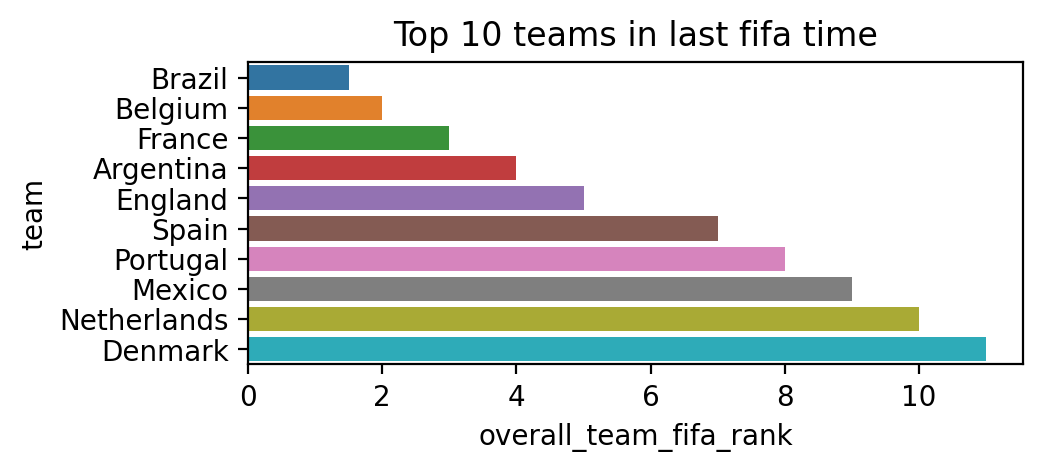

In [598]:
plt.figure(figsize=(5,2),dpi=200)
sns.barplot(data=fifa_rank.head(10),y='team',x='overall_team_fifa_rank')
plt.title("Top 10 teams in last fifa time");

#### Top 10 teams with the highest winning percentage at home and away


In [599]:
def home_percentage(team):
    score = len(df[(df['home_team'] == team) & (df['home_team_result'] == "Win")]) / len(df[df['home_team'] == team]) * 100
    return round(score)
def away_percentage(team):
    score = len(df[(df['away_team'] == team) & (df['home_team_result'] == "Lose")]) / len(df[df['away_team'] == team]) * 100
    return round(score)

In [600]:
fifa_rank['Home_win_Per'] = np.vectorize(home_percentage)(fifa_rank['team'])
fifa_rank['Away_win_Per'] = np.vectorize(away_percentage)(fifa_rank['team'])
fifa_rank['Average_win_Per'] = round((fifa_rank['Home_win_Per'] + fifa_rank['Away_win_Per']) / 2)
fifa_rank_win = fifa_rank.sort_values('Average_win_Per', ascending = False)

#filter only by a team that will participating in QATAR - World cup 2022
fifa_rank_win = fifa_rank_win[(fifa_rank_win['team'].apply(lambda x: x in list_2022))]
fifa_rank_win.head()

,team,home_team_fifa_rank,away_team_fifa_rank,overall_team_fifa_rank,Home_win_Per,Away_win_Per,Average_win_Per
133,Brazil,2,1,1.5,78,60,69.0
170,Spain,7,7,7.0,77,61,69.0
178,France,3,3,3.0,66,57,62.0
183,Germany,12,12,12.0,63,59,61.0
173,IR Iran,21,21,21.0,70,48,59.0


#### Top 10 attacking teams in the last FIFA date

In [601]:
fifa_offense=fifa_features[['team','home_team_mean_offense_score','away_team_mean_offense_score']]
fifa_offense['overall_team_mean_offense_score']=(fifa_offense['home_team_mean_offense_score']+fifa_offense['away_team_mean_offense_score'])/2

fifa_offense=fifa_offense.sort_values(['overall_team_mean_offense_score'], ascending=False)

#filter only by a team that will participating in QATAR - World cup 2022
fifa_offense = fifa_offense[(fifa_offense['team'].apply(lambda x: x in list_2022))]
fifa_offense.head(10)

,team,home_team_mean_offense_score,away_team_mean_offense_score,overall_team_mean_offense_score
154,Argentina,89.0,89.0,89.0
178,France,88.3,88.3,88.3
182,England,88.0,88.0,88.0
133,Brazil,86.3,86.3,86.3
160,Portugal,86.0,86.0,86.0
157,Belgium,85.7,85.7,85.7
170,Spain,85.0,85.0,85.0
185,Poland,84.7,84.7,84.7
169,Uruguay,84.3,84.3,84.3
184,Netherlands,83.0,83.0,83.0


#### Top 10 midfield teams in the last FIFA date

In [602]:
fifa_midfield=fifa_features[['team','home_team_mean_midfield_score','away_team_mean_midfield_score']]
fifa_midfield['overall_team_mean_midfield_score']=(fifa_midfield['home_team_mean_midfield_score']+fifa_midfield['away_team_mean_midfield_score'])/2

fifa_midfield=fifa_midfield.sort_values(['overall_team_mean_midfield_score'], ascending=False)

#filter only by a team that will participating in QATAR - World cup 2022
fifa_midfield = fifa_midfield[(fifa_midfield['team'].apply(lambda x: x in list_2022))]
fifa_midfield.head(10)

,team,home_team_mean_midfield_score,away_team_mean_midfield_score,overall_team_mean_midfield_score
183,Germany,87.8,87.8,87.8
178,France,86.8,86.8,86.8
170,Spain,86.0,86.0,86.0
133,Brazil,85.5,85.5,85.5
157,Belgium,85.5,85.5,85.5
160,Portugal,84.5,84.5,84.5
155,Croatia,84.2,84.2,84.2
182,England,84.0,84.0,84.0
154,Argentina,84.0,84.0,84.0
184,Netherlands,83.5,83.5,83.5


#### Top 10 defense teams in the last FIFA date

In [603]:
fifa_defense=fifa_features[['team','home_team_mean_defense_score','away_team_mean_defense_score']]
fifa_defense['overall_team_mean_defense_score']=(fifa_defense['home_team_mean_defense_score']+fifa_defense['away_team_mean_defense_score'])/2

fifa_defense=fifa_defense.sort_values(['overall_team_mean_defense_score'], ascending=False)

#filter only by a team that will participating in QATAR - World cup 2022
fifa_defense = fifa_defense[(fifa_defense['team'].apply(lambda x: x in list_2022))]
fifa_defense.head(10)

,team,home_team_mean_defense_score,away_team_mean_defense_score,overall_team_mean_defense_score
170,Spain,86.5,86.5,86.5
160,Portugal,85.2,85.2,85.2
184,Netherlands,85.2,85.2,85.2
182,England,85.0,85.0,85.0
133,Brazil,84.8,84.8,84.8
178,France,84.2,84.2,84.2
183,Germany,84.0,84.0,84.0
154,Argentina,82.2,82.2,82.2
175,Morocco,81.2,81.2,81.2
169,Uruguay,81.2,81.2,81.2


#### Top 10 team_goalkeeper_score teams in the last FIFA date

In [604]:
fifa_goalkeeper=fifa_features[['team','home_team_goalkeeper_score','away_team_goalkeeper_score']]
fifa_goalkeeper['overall_team_goalkeeper_score']=(fifa_goalkeeper['home_team_goalkeeper_score']+fifa_goalkeeper['away_team_goalkeeper_score'])/2

fifa_goalkeeper=fifa_goalkeeper.sort_values(['overall_team_goalkeeper_score'], ascending=False)

#filter only by a team that will participating in QATAR - World cup 2022
fifa_goalkeeper = fifa_goalkeeper[(fifa_goalkeeper['team'].apply(lambda x: x in list_2022))]
fifa_goalkeeper.head(10)

,team,home_team_goalkeeper_score,away_team_goalkeeper_score,overall_team_goalkeeper_score
183,Germany,90.0,90.0,90.0
133,Brazil,89.0,89.0,89.0
157,Belgium,89.0,89.0,89.0
179,Costa Rica,88.0,88.0,88.0
185,Poland,87.0,87.0,87.0
178,France,87.0,87.0,87.0
177,Denmark,85.0,85.0,85.0
171,Switzerland,85.0,85.0,85.0
170,Spain,84.0,84.0,84.0
154,Argentina,84.0,84.0,84.0


### Data pre-processing 

incidence of Nan values 

date                                0
home_team                           0
away_team                           0
home_team_continent                 0
away_team_continent                 0
home_team_fifa_rank                 0
away_team_fifa_rank                 0
home_team_total_fifa_points         0
away_team_total_fifa_points         0
home_team_score                     0
away_team_score                     0
home_team_result                    0
away_team_result                    0
home_team_goalkeeper_score       4674
away_team_goalkeeper_score       4794
home_team_mean_defense_score     4745
home_team_mean_offense_score     4561
home_team_mean_midfield_score    4623
away_team_mean_defense_score     4853
away_team_mean_offense_score     4657
away_team_mean_midfield_score    4733
dtype: int64

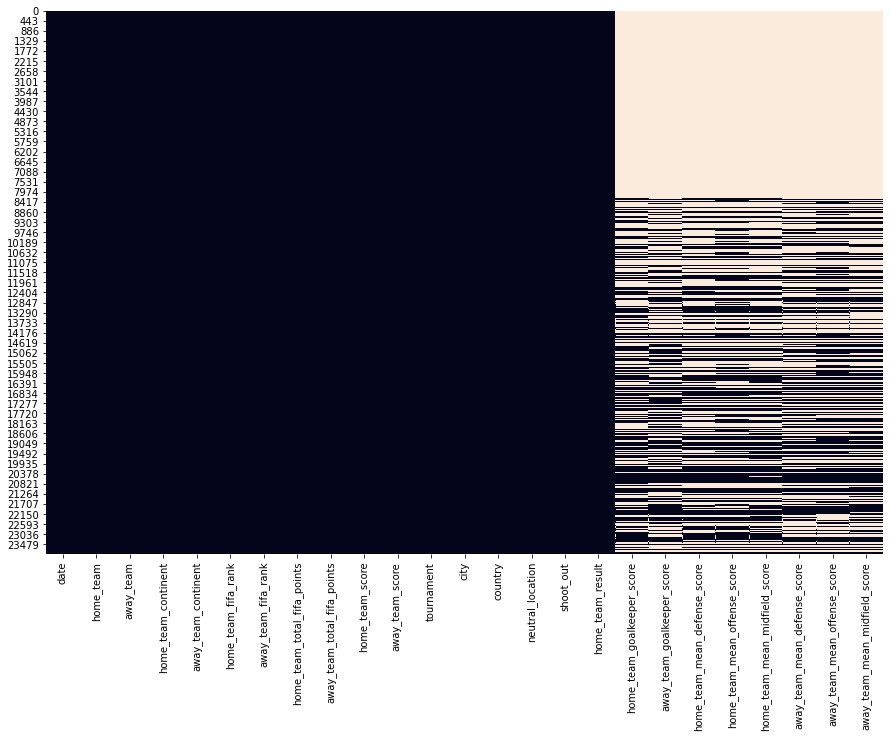

In [605]:
plt.figure(figsize=(15,10))
sns.heatmap(df.isnull(), cbar = False);
master_df.isnull().sum()


fill mean values in the Nan 

In [606]:
# fill mean for na's values in dataset
master_df.iloc[:,17:].describe()

,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
count,4698.000000,4468.000000,4664.000000,4588.000000
mean,77.938740,76.139212,77.342603,77.206822
std,5.549156,5.739948,5.974737,5.693419
min,54.200000,52.800000,59.000000,54.200000
25%,74.800000,72.000000,73.000000,74.000000
50%,77.800000,76.000000,77.000000,77.200000
75%,81.800000,80.200000,81.700000,80.800000
max,93.200000,91.800000,93.000000,93.200000


In [607]:
master_df.iloc[:,17:].columns

Index(['home_team_mean_midfield_score', 'away_team_mean_defense_score',
       'away_team_mean_offense_score', 'away_team_mean_midfield_score'],
      dtype='object')

In [608]:
home_team_features=[] 
for i,features_core in enumerate(df.iloc[:,17:].columns):
    if (i%2) == 0:
        master_df[features_core] = round(master_df.groupby('home_team')[features_core].transform(lambda x: x.fillna(x.mean())))
    else:
        master_df[features_core] = round(master_df.groupby('away_team')[features_core].transform(lambda x: x.fillna(x.mean())))


In [609]:
master_df.isnull().sum()

date                                0
home_team                           0
away_team                           0
home_team_continent                 0
away_team_continent                 0
home_team_fifa_rank                 0
away_team_fifa_rank                 0
home_team_total_fifa_points         0
away_team_total_fifa_points         0
home_team_score                     0
away_team_score                     0
home_team_result                    0
away_team_result                    0
home_team_goalkeeper_score        749
away_team_goalkeeper_score        969
home_team_mean_defense_score     1120
home_team_mean_offense_score       26
home_team_mean_midfield_score     951
away_team_mean_defense_score     1257
away_team_mean_offense_score       14
away_team_mean_midfield_score    1036
dtype: int64

In [610]:
# Teams are not available in FIFA game itself, so they are not less than average performing teams, so giving a average score of 20 for all.
master_df.fillna(20,inplace=True)

### Correlation Matrix


In [611]:
# Mapping numeric values for home_team_result to find the correleations
master_df['home_team_result_numeric'] = master_df['home_team_result'].map({'Win':1, 'Draw':2, 'Lose':0})

In [612]:
master_df.corr()['home_team_result_numeric'].sort_values(ascending=False)


home_team_result_numeric         1.000000
home_team_mean_midfield_score    0.156315
home_team_mean_defense_score     0.153331
home_team_score                  0.127916
home_team_goalkeeper_score       0.114063
away_team_fifa_rank              0.111366
home_team_mean_offense_score     0.041340
home_team_total_fifa_points      0.015498
away_team_total_fifa_points     -0.047726
away_team_mean_offense_score    -0.096122
away_team_mean_midfield_score   -0.096737
away_team_mean_defense_score    -0.096900
away_team_goalkeeper_score      -0.097403
home_team_fifa_rank             -0.186355
away_team_score                 -0.464635
Name: home_team_result_numeric, dtype: float64

In [613]:
#Dropping unnecessary colums
master_df = master_df.drop(['date', 'home_team_result','away_team_result','home_team_continent', 'away_team_continent', 'home_team_total_fifa_points', 'away_team_total_fifa_points', 'home_team_score','away_team_score'],axis=1)

In [614]:
master_df.to_csv('data/train_features.csv',index=False)

## Get the qatar features

In [615]:
qatar_features=pd.merge(fifa_rank_win,fifa_offense, on='team')
qatar_features=pd.merge(qatar_features,fifa_midfield, on='team')
qatar_features=pd.merge(qatar_features,fifa_defense, on='team')
qatar_features=pd.merge(qatar_features,fifa_goalkeeper, on='team')
qatar_features=qatar_features[['team','overall_team_fifa_rank','Average_win_Per','overall_team_mean_offense_score',
                            'overall_team_mean_midfield_score','overall_team_mean_defense_score','overall_team_goalkeeper_score']]
qatar_features=qatar_features.rename(columns={"overall_team_fifa_rank":"rank","Average_win_Per":"win_Percentage","overall_team_mean_offense_score":"attack",
                                "overall_team_mean_midfield_score":"midfield","overall_team_mean_defense_score":"defense","overall_team_goalkeeper_score":"goalkeeper"})

In [616]:
qatar_features

,team,rank,win_Percentage,attack,midfield,defense,goalkeeper
0,Brazil,1.5,69.0,86.3,85.5,84.8,89.0
1,Spain,7.0,69.0,85.0,86.0,86.5,84.0
2,France,3.0,62.0,88.3,86.8,84.2,87.0
3,Germany,12.0,61.0,82.7,87.8,84.0,90.0
4,IR Iran,21.0,59.0,75.3,69.0,69.0,73.0
5,Argentina,4.0,58.0,89.0,84.0,82.2,84.0
6,England,5.0,58.0,88.0,84.0,85.0,83.0
7,Portugal,8.0,58.0,86.0,84.5,85.2,82.0
8,Netherlands,10.0,58.0,83.0,83.5,85.2,81.0
9,Croatia,16.0,54.0,76.7,84.2,77.8,82.0


#### export features 

In [617]:
qatar_features.to_csv('data/qatar_features.csv')